# Handwritten Digit Recognition
- 赵福方宸
- Dataset = MNIST
- Frameworks = PyTorch
- 2021111252

### 对一些必要的包的导入

In [33]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

### 这里一开始是想通过google的云端进行数据集的下载和使用，但是下载google.colab的时候一直失败，就放弃了这个想法。

In [34]:
import os
#from google.colab import drive

### 下载数据集，定义Transformer

### 这里由于版本问题，出现警告，但仍然运行成功，没有出现下载提示，是因为本地位置上面已经有了相应的数据集了

In [35]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('E:/研究生/选课/高级机器学习/handwritten_digit_recognition/MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('E:/研究生/选课/高级机器学习/handwritten_digit_recognition/MNIST_data/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

### 对数据集中的数据进行观察

###### 根据上面代码块对trainloader的定义和valloader的定义，这里对图片的shape进行输出，可以看到，每个label都有64个图片（上个代码块定义），每个图片都是28x28的规格。

In [36]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


###### 显示第一张的图片（由于在对trainloader定义时，shuffer==true，所以图片为随机抽取），这里显示的是如下的手写体数字。

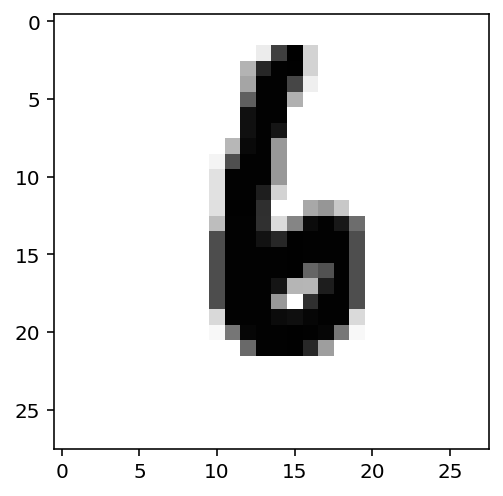

In [37]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

###### 将60个图片按10x6排列并展示，关闭坐标轴

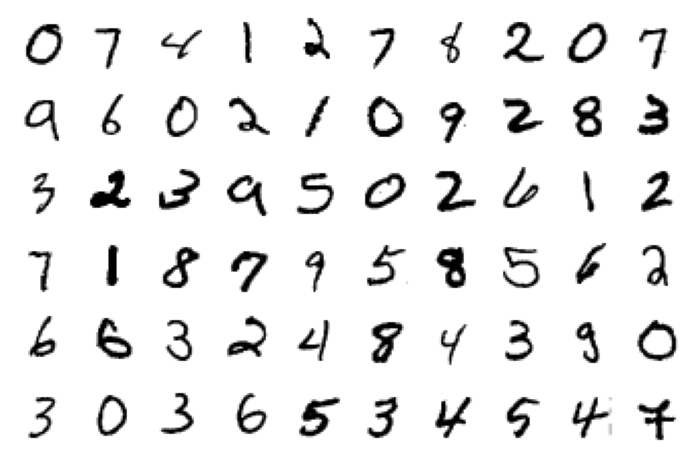

In [38]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### 定义全连接神经网络

![ML](img/mlp_mnist.png)

###### 下面代码块的神经网络是依据上面的图片来定义的，输入层有784个节点，有两层隐藏层，隐藏层一有128个节点，采用relu激活函数，隐藏层二有64个节点，采用relu激活函数。输出层由10个节点构成，用softmax进行激活并归一，损失则采用交叉熵的方法求出，在进行输出。

In [39]:
from torch import nn

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


###### 采用GPU运行模型程序

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

###### 定义损失函数

In [41]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images.cuda())
loss = criterion(logps, labels.cuda())

In [42]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0032,  0.0032,  0.0032,  ...,  0.0032,  0.0032,  0.0032],
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        ...,
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010]],
       device='cuda:0')


###### 引入优化器

这里先进行优化测试，优化器采用SGD，学习率为0.01，momentum为0.5

In [43]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [44]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images.cuda())
loss = criterion(output, labels.cuda())
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-2.4724e-02, -1.1804e-02, -1.1810e-02,  ..., -5.2097e-03,
         -2.9582e-02,  1.8491e-02],
        [-3.4521e-02, -1.1119e-02, -3.4498e-02,  ...,  1.0769e-02,
         -1.6627e-02, -2.7596e-02],
        [-1.4860e-02,  2.2027e-02,  1.4392e-02,  ..., -1.4808e-02,
         -1.0875e-02, -2.8767e-02],
        ...,
        [-7.2232e-03, -1.5126e-02,  2.2519e-02,  ...,  3.3688e-02,
         -1.4471e-02, -2.2136e-02],
        [ 4.3204e-03, -1.2253e-02, -5.1245e-03,  ..., -1.3838e-03,
         -2.5221e-02,  4.8086e-03],
        [ 6.5823e-03, -1.7191e-03, -6.4373e-06,  ...,  2.9467e-02,
          1.0437e-02,  1.4944e-02]], device='cuda:0', requires_grad=True)
Gradient - tensor([[-1.8003e-03, -1.8003e-03, -1.8003e-03,  ..., -1.8003e-03,
         -1.8003e-03, -1.8003e-03],
        [-6.8772e-04, -6.8772e-04, -6.8772e-04,  ..., -6.8772e-04,
         -6.8772e-04, -6.8772e-04],
        [ 1.3688e-03,  1.3688e-03,  1.3688e-03,  ...,  1.3688e-03,
      

In [45]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-2.4706e-02, -1.1786e-02, -1.1792e-02,  ..., -5.1917e-03,
         -2.9564e-02,  1.8509e-02],
        [-3.4514e-02, -1.1112e-02, -3.4491e-02,  ...,  1.0776e-02,
         -1.6620e-02, -2.7589e-02],
        [-1.4874e-02,  2.2013e-02,  1.4378e-02,  ..., -1.4821e-02,
         -1.0889e-02, -2.8781e-02],
        ...,
        [-7.1700e-03, -1.5073e-02,  2.2572e-02,  ...,  3.3741e-02,
         -1.4418e-02, -2.2083e-02],
        [ 4.3150e-03, -1.2258e-02, -5.1299e-03,  ..., -1.3891e-03,
         -2.5226e-02,  4.8033e-03],
        [ 6.5815e-03, -1.7200e-03, -7.3028e-06,  ...,  2.9466e-02,
          1.0436e-02,  1.4944e-02]], device='cuda:0', requires_grad=True)


### 这里对神经网络进行训练

同样采用SGD，学习率为0.003，momentum为0.9，训练轮数为15轮，最后输出训练所用的总时间

In [51]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images.cuda())
        loss = criterion(output, labels.cuda())
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.03286583815449486
Epoch 1 - Training loss: 0.022247231410123032
Epoch 2 - Training loss: 0.01910328682630291
Epoch 3 - Training loss: 0.017374212929674525
Epoch 4 - Training loss: 0.015971822470401832
Epoch 5 - Training loss: 0.015097716417085297
Epoch 6 - Training loss: 0.013918377154463521
Epoch 7 - Training loss: 0.013121198952871761
Epoch 8 - Training loss: 0.01262450189913653
Epoch 9 - Training loss: 0.012093177624885322
Epoch 10 - Training loss: 0.011407518014204745
Epoch 11 - Training loss: 0.010983096538782228
Epoch 12 - Training loss: 0.010616352343651228
Epoch 13 - Training loss: 0.01005494498588735
Epoch 14 - Training loss: 0.009726871089781298

Training Time (in minutes) = 1.4340676148732503


将优化器所用的优化算法改为Adam，其他参数不改变进行对比。

In [46]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images.cuda())
        loss = criterion(output, labels.cuda())
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.32656886909149097
Epoch 1 - Training loss: 0.1674773992676693
Epoch 2 - Training loss: 0.13580289769864112
Epoch 3 - Training loss: 0.11956634592544883
Epoch 4 - Training loss: 0.10519827678136881
Epoch 5 - Training loss: 0.10148859424278267
Epoch 6 - Training loss: 0.09772813859840494
Epoch 7 - Training loss: 0.09054466678541519
Epoch 8 - Training loss: 0.08343547264234161
Epoch 9 - Training loss: 0.0803264742938063
Epoch 10 - Training loss: 0.08065257753545382
Epoch 11 - Training loss: 0.07053284374336753
Epoch 12 - Training loss: 0.07399444854630878
Epoch 13 - Training loss: 0.07151458657504658
Epoch 14 - Training loss: 0.06775897650053349

Training Time (in minutes) = 1.4761688709259033


设置view_classify来观察图片和图片的相应预测

In [52]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9),ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 5


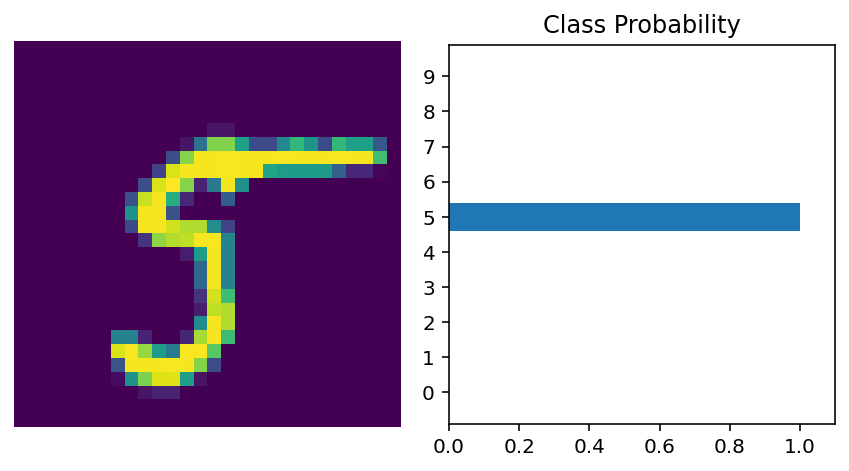

In [57]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

### 打印出模型的最终效果

In [54]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.98
